In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from fairlearn.metrics import MetricFrame
from sklearn import metrics as skm
import seaborn as sns
import os.path as path
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle

pd.set_option('display.max_rows', 10)
sns.set()
sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)
# pd.options.display.float_format = '{:.2f}'.format


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [37]:
# NEED MODIFY
EPOCH = 250
LAMBDA = 0.01
FOLDER = 'fairst_all_models/e_250_lambda_0_5'
PRED_FILE_NAME = "fused_model_pred_0.5_1641211889.0977252.csv"

In [4]:
CITY = "N_"
save_dir = CITY + 'reg_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if not os.path.exists(save_dir_preprocess):
    os.makedirs(save_dir_preprocess)

if not os.path.exists(save_dir_models):
    os.makedirs(save_dir_models)
    
if not os.path.exists(save_dir_forecast):
    os.makedirs(save_dir_forecast)
    
if not os.path.exists(save_dir_fairst):
    os.makedirs(save_dir_fairst)

In [39]:
pred_df = pd.read_csv(os.path.join(save_dir_fairst, FOLDER, PRED_FILE_NAME), index_col = 0)
gt_df = pd.read_csv(os.path.join(save_dir_fairst, "test_df_cut.csv"), index_col = 0)
pos_info = pd.read_csv(os.path.join(save_dir_fairst, "df_demo.csv"), index_col = 0)
income_info = pd.read_csv(os.path.join(save_dir_fairst, "df_income.csv"), index_col = 0)
income_info = income_info.groupby(by = "cell_num").mean().reset_index()
income_info.income_group = income_info.income_group.astype(int)
demo_raw = pd.read_csv(os.path.join(save_dir_fairst, "demo_raw.csv"))
pred_df.index = pd.to_datetime(pred_df.index)
gt_df.index = pd.to_datetime(gt_df.index)
gt_df = gt_df[gt_df.index.isin(pred_df.index)]
normalized_pop_df = pd.read_csv(os.path.join(save_dir_fairst, "normalized_pop_df.csv"), index_col = 0)

In [40]:
gt_df = gt_df[gt_df.columns[gt_df.columns.isin(pred_df.columns)]]

In [41]:
def df_transform(df):
    pos_l = df.columns
    df_trans = pd.DataFrame(columns = ["pos", "outflow"])

    for i in np.arange(len(pos_l)):
        pos = pos_l[i]
        temp = df[pos].to_frame()
        temp["pos"] = [temp.columns.values[0]]*len(temp)
        temp.rename(columns = {pos: "outflow"}, inplace = True)
        df_trans = df_trans.append(temp)
        
    return df_trans

In [42]:
pred_df_month = pred_df.groupby(pred_df.index.month).sum()
gt_df = gt_df[gt_df.index.isin(pred_df.index)]
gt_df_month = gt_df.groupby(gt_df.index.month).sum()



In [43]:
df_pred_trans = df_transform(pred_df_month)
df_gt_trans = df_transform(gt_df_month)
gt_final = df_gt_trans.merge(pos_info)
pred_final = df_pred_trans.merge(pos_info)

pred_final_m = pred_final.merge(income_info, on = 'cell_num')
gt_final_m = gt_final.merge(income_info, on = 'cell_num')

gt_final_m.outflow = gt_final_m.outflow.astype(int)

R^2      0.899148
MAE    884.859408
dtype: object
------------------------------
                   R^2          MAE
income_group                       
0             0.907094   565.253756
1             0.893083  1057.121438

R^2 diff: 0.014011610425166965
MAE diff: 491.86768170636583
------------------------------


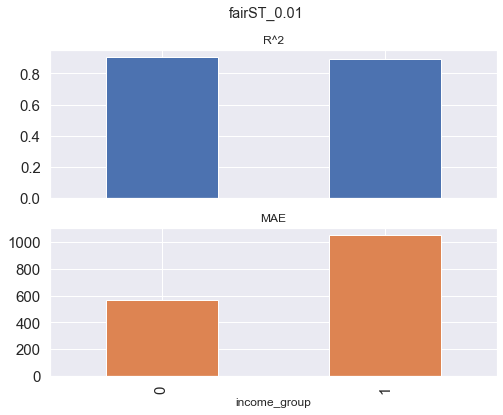

In [44]:
metric_frame_fairST = MetricFrame(metric = {"R^2": skm.r2_score,
                                           "MAE": skm.mean_absolute_error},
                                           sensitive_features = pred_final_m.income_group,
                                           y_true = gt_final_m.outflow,
                                           y_pred = pred_final_m.outflow)

print(metric_frame_fairST.overall)
print("-"*30)
print(metric_frame_fairST.by_group)
print()
print("R^2 diff:",metric_frame_fairST.difference()["R^2"])
print("MAE diff:", metric_frame_fairST.difference()["MAE"])
print("-"*30)
# print("RFG:", rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num))

metric_frame_fairST.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='fairST_' + str(LAMBDA), fontsize = 15)

# plt.savefig(os.path.join(save_dir_fairst, FOLDER, "fair_st_metric"))

In [45]:
normalized_pop_df["cell_num"] = normalized_pop_df.index
cell2group_df = gt_final_m.groupby("cell_num").mean().reset_index()
cell2group_df["income_group"] = cell2group_df["income_group"].astype(int)
cell_pop_df = normalized_pop_df.merge(cell2group_df, on = "cell_num")

g1_pop = cell_pop_df[cell_pop_df["income_group"] == 1].normalized_pop.sum()
g2_pop = cell_pop_df[cell_pop_df["income_group"] == 0].normalized_pop.sum()
group_index = pred_final_m.income_group
g1_pred = pred_final_m.outflow[group_index[group_index == 1].index]
g2_pred = pred_final_m.outflow[group_index[group_index == 0].index]

bike_g1 = g1_pred.sum() / len(pred_final_m.outflow)
bike_g2 = g2_pred.sum()/ len(pred_final_m.outflow)
rfg = bike_g1 /g1_pop - bike_g2 /g2_pop

In [46]:
PATH1 = os.path.join(save_dir_fairst, "fairst_all_models", CITY + "fairst_summary.csv")

if path.exists(PATH1):
    fairst_summary = pd.read_csv(PATH1, index_col = 0)
else:
    fairst_summary = pd.DataFrame(columns = [ "epoch", "lambda", "r2", "r2_diff", "mae", "mae_diff", "rfg"])

In [1]:
new_row = {"epoch": EPOCH,
            "lambda": LAMBDA,
           "r2": metric_frame_fairST.overall["R^2"],
           "r2_diff": metric_frame_fairST.difference()["R^2"],
           "mae": metric_frame_fairST.overall["MAE"],
           "mae_diff":metric_frame_fairST.difference()["MAE"],
           "rfg": rfg}

fairst_summary = fairst_summary.append(new_row, ignore_index = True)
fairst_summary = fairst_summary.sort_values("lambda")
fairst_summary.reset_index(drop = True, inplace = True)
fairst_summary.to_csv(PATH1)

In [18]:
PATH2 = os.path.join(save_dir_models, CITY + "model_summary.csv")
if path.exists(PATH2):
    model_summary = pd.read_csv(PATH2, index_col = 0)
else:
    print("NO FILE")

In [49]:
fairst_summary_plt = fairst_summary

Text(0.5, 1.0, 'N_Model visualization with fairST')

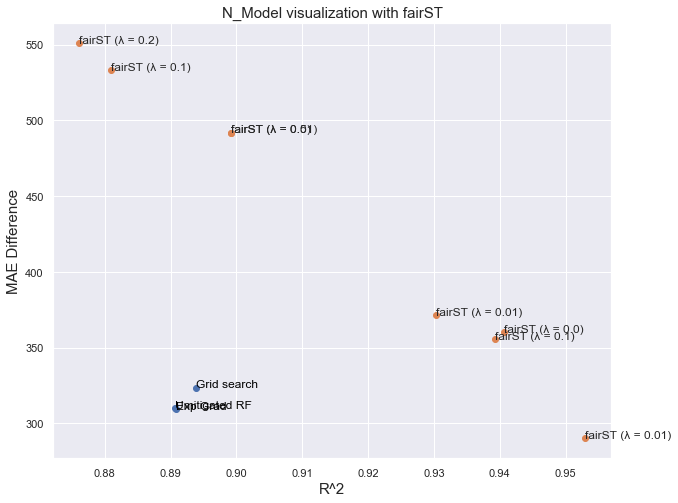

In [50]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
plt.scatter(model_summary["r2"], model_summary["mae_diff"])

# unmitigated random forest
# plt.scatter(model_summary.loc["random_forest", "r2"], model_summary.loc["random_forest", "mae_diff"], color = 'black')
plt.text(model_summary.loc["random_forest", "r2"], model_summary.loc["random_forest", "mae_diff"], "Umitigated RF", color = 'black')

# exponentiated gradient
# plt.scatter(model_summary.loc["random_forest", "r2"], model_summary.loc["random_forest", "mae_diff"], color = 'black')
plt.text(model_summary.loc["exp_grad", "r2"], model_summary.loc["exp_grad", "mae_diff"], "Exp Grad", color = 'black')

# plt.scatter(metric_frame_eg.overall['R^2'], metric_frame_eg.difference()['MAE'], color = 'green')
plt.text(model_summary.loc["grid_search", "r2"], model_summary.loc["grid_search", "mae_diff"], "Grid search", color = 'black')


plt.scatter(fairst_summary_plt["r2"], fairst_summary_plt["mae_diff"])

for index, row in fairst_summary_plt.iterrows():
    plt.text(row["r2"], row["mae_diff"], "fairST (λ = {})".format(str(row["lambda"])))


plt.xlabel("R^2", fontsize = 15)
plt.ylabel("MAE Difference", fontsize = 15)
plt.title(CITY + "Model visualization with fairST", fontsize = 15)
# plt.xlim((0.806, 0.811))
# plt.savefig(os.path.join(save_dir_fairst, CITY + "models_scatter_res"))

In [51]:
gt_final_year = gt_final_m.groupby(by = "cell_num").sum()["outflow"].to_frame().reset_index()
pred_final_year = pred_final_m.groupby(by = "cell_num").sum()["outflow"].to_frame().reset_index()

gt_final_year = gt_final_year.merge(pos_info)
pred_final_year = pred_final_year.merge(pos_info)

for row, col in gt_final_year.iterrows():
    gt_final_year.at[row, 'geometry'] = shapely.wkt.loads(gt_final_year.loc[row]['geometry'])
for row, col in pred_final_year.iterrows():
    pred_final_year.at[row, 'geometry'] = shapely.wkt.loads(pred_final_year.loc[row]['geometry'])

In [52]:
pred_final_year.to_csv(os.path.join(save_dir_fairst, "fairst_pred.csv"))

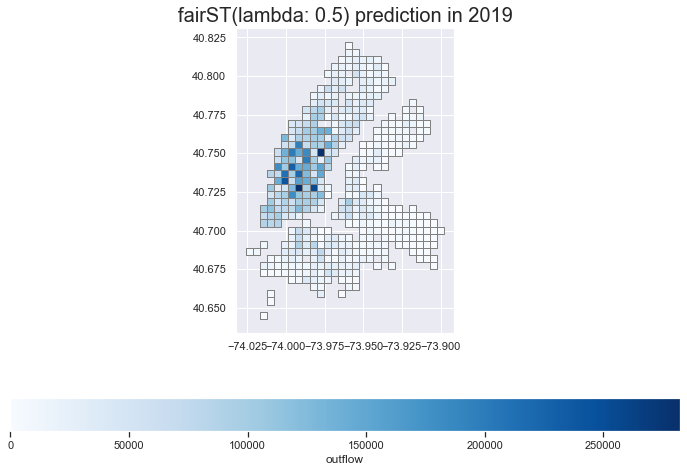

In [18]:
pred_final_year = gpd.GeoDataFrame(pred_final_year, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

pred_final_year.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(12, 8),  
                    legend = True, legend_kwds={'label': "outflow", 'orientation': "horizontal"})
plt.title("fairST(lambda: {}) prediction in 2019".format(str(LAMBDA)), fontsize=20)
plt.savefig(os.path.join(save_dir_fairst, FOLDER, CITY + "fairst_2019_pred"))


## analysis
### run below after have run all model and save to files

Text(0, 0.5, 'MAE')

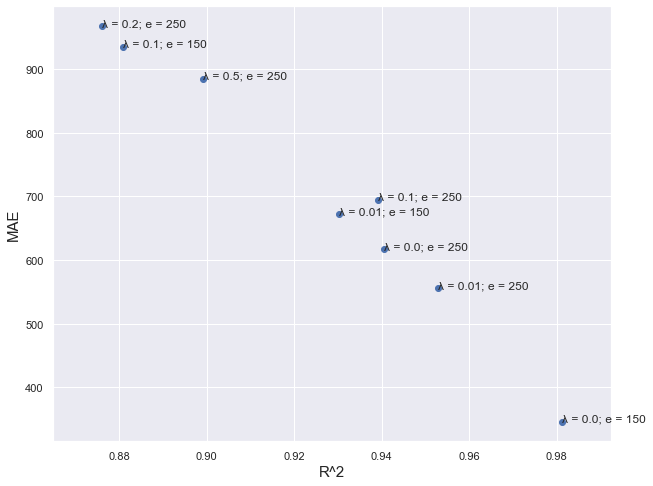

In [25]:
plt.figure(figsize = (10, 8))
plt.scatter(fairst_summary["r2"], fairst_summary["mae"])

for idx, row in fairst_summary.iterrows():
    plt.text(row["r2"], row["mae"], "λ = " + str(row["lambda"]) + "; e = " + str(int(row["epoch"])), size = 12)

plt.xlabel("R^2", fontsize = 15)
plt.ylabel("MAE", fontsize = 15)

Text(0, 0.5, 'rfg')

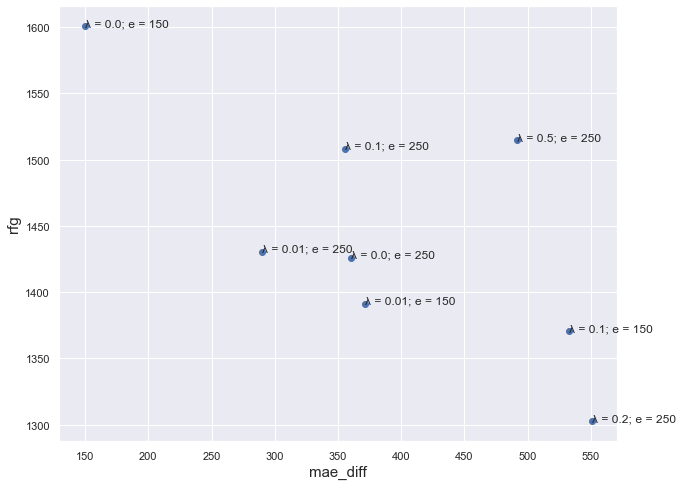

In [26]:
plt.figure(figsize = (10, 8))
plt.scatter(fairst_summary["mae_diff"], fairst_summary["rfg"])

for idx, row in fairst_summary.iterrows():
    plt.text(row["mae_diff"], row["rfg"], "λ = " + str(row["lambda"]) + "; e = " + str(int(row["epoch"])), size = 12)

plt.xlabel("mae_diff", fontsize = 15)
plt.ylabel("rfg", fontsize = 15)

Text(0, 0.5, 'mae_diff')

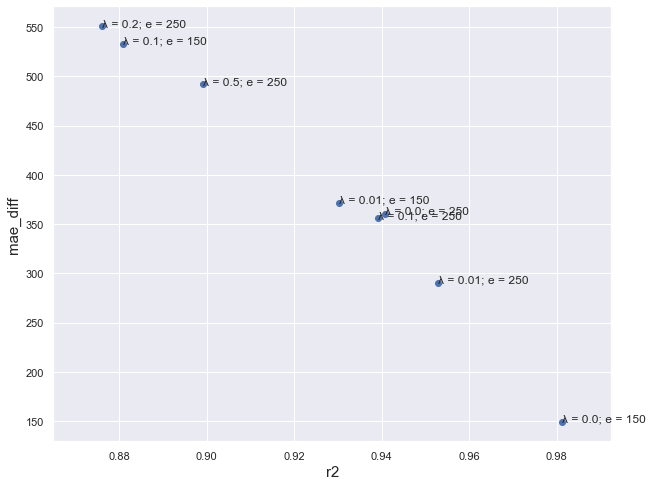

In [27]:
plt.figure(figsize = (10, 8))
plt.scatter(fairst_summary["r2"], fairst_summary["mae_diff"])

for idx, row in fairst_summary.iterrows():
    plt.text(row["r2"], row["mae_diff"], "λ = " + str(row["lambda"]) + "; e = " + str(int(row["epoch"])), size = 12)

plt.xlabel("r2", fontsize = 15)
plt.ylabel("mae_diff", fontsize = 15)

In [36]:
fairst_summary = pd.read_csv(os.path.join(save_dir_fairst, "fairst_all_models", CITY + "fairst_summary.csv"), index_col = 0)

In [51]:
# fairst_summary = fairst_summary.sort_values('mae_diff')
fairst_summary_plt = fairst_summary.iloc[0]

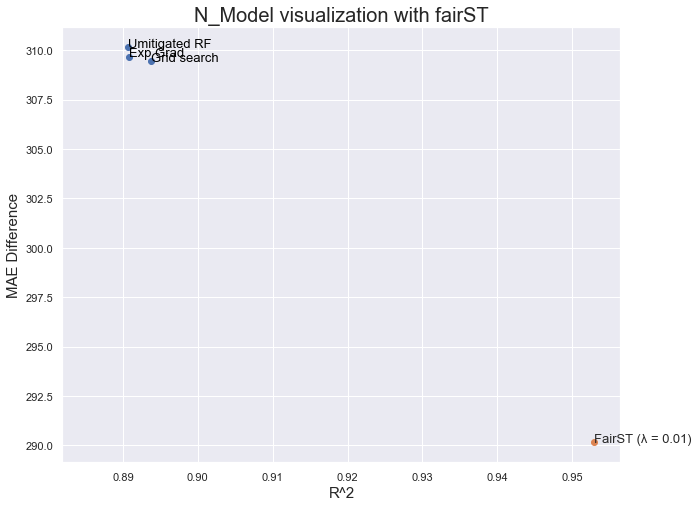

In [22]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
plt.scatter(model_summary["r2"], model_summary["mae_diff"])

# unmitigated random forest
# plt.scatter(model_summary.loc["random_forest", "r2"], model_summary.loc["random_forest", "mae_diff"], color = 'black')
plt.text(model_summary.loc["random_forest", "r2"], model_summary.loc["random_forest", "mae_diff"], "Umitigated RF", color = 'black', size = 13)

# exponentiated gradient
# plt.scatter(model_summary.loc["random_forest", "r2"], model_summary.loc["random_forest", "mae_diff"], color = 'black')
plt.text(model_summary.loc["exp_grad", "r2"], model_summary.loc["exp_grad", "mae_diff"], "Exp Grad", color = 'black', size = 13)

# plt.scatter(metric_frame_eg.overall['R^2'], metric_frame_eg.difference()['MAE'], color = 'green')
plt.text(model_summary.loc["grid_search", "r2"], model_summary.loc["grid_search", "mae_diff"], "Grid search", color = 'black', size = 13)

plt.scatter(fairst_summary_plt["r2"], fairst_summary_plt["mae_diff"])

plt.text(fairst_summary_plt["r2"], fairst_summary_plt["mae_diff"], "FairST (λ = {})".format(str(fairst_summary_plt["lambda"])), size = 13)


plt.xlabel("R^2", fontsize = 15)
plt.ylabel("MAE Difference", fontsize = 15)
plt.title(CITY + "Model visualization with fairST", fontsize = 20)
# plt.xlim((0.806, 0.811))
plt.savefig(os.path.join(save_dir_fairst, CITY + "models_scatter_res"))